## Extract Text from Parsehub

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import string

from pathlib import Path
from pprint import pprint

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Pessimo Pet
[nltk_data]     Puffy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Pessimo Pet
[nltk_data]     Puffy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Import scrapped articles

Change the name of Article accordingly, and scrapped content column change to "Content".

In [6]:
scrapped_data = input("Enter the CSV file name (including .csv extension): ")

Enter the CSV file name (including .csv extension):  Digital_Journal.csv


In [7]:
df = pd.read_csv(scrapped_data)
df

id                                    selection1_name  \
0      1  Taiwan bans government agencies from using Dee...   
1      2  Adapting to evolving cyber threats: A conversa...   
2      3  Shireesh Annam on why AI is retail’s next comp...   
3      4  How to choose the right VPN: Free trials that ...   
4      5  How Punchcard is turning AI disruption into gr...   
..   ...                                                ...   
111  112  CES 2025: Scanner identifies atoms at the spee...   
112  113  CES 2025: Wisson’s Pliabot-powered drone makes...   
113  114  Political chess or true beliefs? Zuckerberg’s ...   
114  115  New AI platform performs preclinical small mol...   
115  116  Diabetes: Taking high-dose vitamin D supplemen...   

                                        selection1_url  \
0    https://www.digitaljournal.com/tech-science/ta...   
1    https://www.digitaljournal.com/tech-science/ad...   
2    https://www.digitaljournal.com/tech-science/sh...   
3    https://www.digitaljournal.com/tech-science/ho...   
4    https://www.digitaljournal.com/business/how-pu...   
..                                                 ...   
111  https://www.digitaljournal.com/tech-science/ce...   
112  https://www.digitaljournal.com/tech-science/ce...   
113  https://www.digitaljournal.com/tech-science/po...   
114  https://www.digitaljournal.com/tech-science/ne...   
115  https://www.digitaljournal.com/tech-science/di...   

                                               Content  
0    DeepSeek launched its R1 chatbot last month, c...  
1    Image courtesy of Nikhil Chandrashekar\nOpinio...  
2    Photo courtesy of Shireesh Annam\nOpinions exp...  
3    Photo by Stefan Coders On Pexels\nOpinions exp...  
4    Photo by Digital Journal\nThe scent of freshly...  
..                                                 ...  
111  ABLASCANTM overcomes the limitations of curren...  
112  Photo courtesy of Wisson Robotics\nOpinions ex...  
113  Meta's Mark Zuckerberg. — © GETTY IMAGES NORTH...  
114  Scientists using laboratory instruments. — Ima...  
115  A bottle of B-complex vitamin pills. Image by ...  

[116 rows x 4 columns]

### Upload prev top_20_words file

Change file name according and change variable name.

In [10]:
keyword_list = input("Enter the file name (including extension, e.g., 'Top_200_words_revised.txt'): ")

Enter the file name (including extension, e.g., 'Top_200_words_revised.txt'):  top_200_words_revised.txt


In [11]:
# Open the file in read mode and store its content into the ESG_keywords variable
with open(keyword_list, 'r') as file:
    ESG_keywords = file.read().splitlines()  # .splitlines() to split by each line

# Now ESG_keywords contains the list of keywords from the text file
print(ESG_keywords)

['Energy', 'Renewable', 'EMDE', 'electricity', 'renewables', 'finance', 'income', 'investment', 'indicator', 'Brazil', 'fuel', 'consumption', 'power', 'deployment', 'climate', 'fossil', 'solar', 'generation', 'wind', 'technology', 'clean', 'transition', 'international', 'global', 'EMDEs', 'biofuels', 'hydropower', 'NDCs', 'commitment', 'assessment', 'challenge', 'population', 'policy', 'rural', 'urban', 'development', 'countries', 'global', 'progress', 'commitment']


## Text preprocessing

In [13]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add additional stopwords
additional_stopwords = {"example", "additional", "words", "specific", "said","like"}  # Replace with your custom stopwords
stop_words.update(additional_stopwords)

def preprocess_text_nltk(text):
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize and remove stopwords and punctuation
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return ' '.join(lemmatized_tokens)

# Apply the NLTK preprocessing function to the articles
df['processed_text'] = df['Content'].apply(preprocess_text_nltk)

In [14]:
ESG_keywords_set = set(ESG_keywords)

In [15]:
# Filter articles based on keyword presence (optional)
def contains_ESG_keywords(text):
    return any(keyword in text for keyword in ESG_keywords_set)

df['contains_ESG'] = df['processed_text'].apply(contains_ESG_keywords)

In [16]:
# Keep only articles that contain ESG-related keywords
df_esg = df[df['contains_ESG'] == True]

In [17]:
df_esg

id                                    selection1_name  \
0      1  Taiwan bans government agencies from using Dee...   
1      2  Adapting to evolving cyber threats: A conversa...   
2      3  Shireesh Annam on why AI is retail’s next comp...   
3      4  How to choose the right VPN: Free trials that ...   
4      5  How Punchcard is turning AI disruption into gr...   
..   ...                                                ...   
111  112  CES 2025: Scanner identifies atoms at the spee...   
112  113  CES 2025: Wisson’s Pliabot-powered drone makes...   
113  114  Political chess or true beliefs? Zuckerberg’s ...   
114  115  New AI platform performs preclinical small mol...   
115  116  Diabetes: Taking high-dose vitamin D supplemen...   

                                        selection1_url  \
0    https://www.digitaljournal.com/tech-science/ta...   
1    https://www.digitaljournal.com/tech-science/ad...   
2    https://www.digitaljournal.com/tech-science/sh...   
3    https://www.digitaljournal.com/tech-science/ho...   
4    https://www.digitaljournal.com/business/how-pu...   
..                                                 ...   
111  https://www.digitaljournal.com/tech-science/ce...   
112  https://www.digitaljournal.com/tech-science/ce...   
113  https://www.digitaljournal.com/tech-science/po...   
114  https://www.digitaljournal.com/tech-science/ne...   
115  https://www.digitaljournal.com/tech-science/di...   

                                               Content  \
0    DeepSeek launched its R1 chatbot last month, c...   
1    Image courtesy of Nikhil Chandrashekar\nOpinio...   
2    Photo courtesy of Shireesh Annam\nOpinions exp...   
3    Photo by Stefan Coders On Pexels\nOpinions exp...   
4    Photo by Digital Journal\nThe scent of freshly...   
..                                                 ...   
111  ABLASCANTM overcomes the limitations of curren...   
112  Photo courtesy of Wisson Robotics\nOpinions ex...   
113  Meta's Mark Zuckerberg. — © GETTY IMAGES NORTH...   
114  Scientists using laboratory instruments. — Ima...   
115  A bottle of B-complex vitamin pills. Image by ...   

                                        processed_text  contains_ESG  
0    deepseek launched chatbot last month claiming ...          True  
1    image courtesy nikhil chandrashekar opinion ex...          True  
2    photo courtesy shireesh annam opinion expresse...          True  
3    photo stefan coder pexels opinion expressed di...          True  
4    photo digital journal scent freshly ground cof...          True  
..                                                 ...           ...  
111  ablascantm overcomes limitation current method...          True  
112  photo courtesy wisson robotics opinion express...          True  
113  meta mark zuckerberg getty image north justin ...          True  
114  scientist using laboratory instrument image ti...          True  
115  bottle vitamin pill image ragesoss cc study re...          True  

[106 rows x 6 columns]

In [18]:
# Tokenize the 'processed_text' column into an array of Unicode tokens
processed_text_tokens = df_esg['processed_text'].apply(lambda x: nltk.word_tokenize(x))

# Convert to a list of arrays of Unicode tokens
processed_text_unicode_array = processed_text_tokens.to_numpy()

## Prepare Word Representation

In [20]:
# Enter codes here
dictionary = corpora.Dictionary(processed_text_unicode_array)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text_unicode_array]

## Create LDA Model

### LDA Model with 10 topics

In [23]:
# Enter code here
topic_num = 12
word_num = 10

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = topic_num, id2word = dictionary, passes=20)

pprint(ldamodel.print_topics(num_topics=topic_num, num_words=word_num))

#compute perplexity 
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))

[(0,
  '0.009*"game" + 0.007*"nintendo" + 0.006*"switch" + 0.006*"china" + '
  '0.005*"deriviere" + 0.005*"ai" + 0.005*"chip" + 0.005*"age" + 0.005*"rule" '
  '+ 0.004*"u"'),
 (1,
  '0.009*"data" + 0.007*"security" + 0.006*"company" + 0.006*"percent" + '
  '0.005*"also" + 0.004*"social" + 0.004*"chandrashekar" + '
  '0.004*"organization" + 0.003*"threat" + 0.003*"fire"'),
 (2,
  '0.007*"data" + 0.007*"ai" + 0.006*"musk" + 0.006*"mukkala" + 0.006*"galaxy" '
  '+ 0.006*"star" + 0.004*"new" + 0.004*"cancer" + 0.004*"agent" + '
  '0.004*"operator"'),
 (3,
  '0.020*"ai" + 0.007*"data" + 0.006*"technology" + 0.005*"business" + '
  '0.005*"system" + 0.005*"digital" + 0.005*"solution" + 0.004*"new" + '
  '0.004*"industry" + 0.004*"company"'),
 (4,
  '0.016*"pi" + 0.013*"treatment" + 0.012*"periodontitis" + 0.011*"study" + '
  '0.008*"could" + 0.005*"patient" + 0.005*"approach" + 0.005*"disease" + '
  '0.005*"condition" + 0.005*"identified"'),
 (5,
  '0.020*"levven" + 0.015*"minute" + 0.013*"ke

### Visualise topics and Keywords

In [25]:
# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.104952 -0.007060       1        1  20.215853
8      0.103140  0.015660       2        1  14.849751
1      0.072801 -0.042324       3        1  13.714933
6      0.140488  0.053872       4        1  11.316561
7      0.002929 -0.120492       5        1  10.258661
2     -0.029110 -0.062156       6        1   7.515948
9     -0.120552 -0.100861       7        1   6.694610
0     -0.052448 -0.043133       8        1   5.314720
11     0.012408  0.005201       9        1   4.696099
5     -0.016935  0.119773      10        1   2.897154
10    -0.085863  0.101230      11        1   1.462556
4     -0.131810  0.080291      12        1   1.063153, topic_info=            Term        Freq       Total Category  logprob  loglift
1309       study   50.000000   50.000000  Default  30.0000  30.0000
9             ai  406.000000  406.000000  Default  29.0000  29.0000
4220   treatment   35.000000   35.000000  Default  28.0000  28.0000
3557      levven   24.000000   24.000000  Default  27.0000  27.0000
1480       apple   48.000000   48.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
584     research    1.270007   50.707923  Topic12  -5.8197   0.8569
650     strategy    1.269820   40.439340  Topic12  -5.8198   1.0830
2713     finding    1.269760   13.467695  Topic12  -5.8199   2.1825
1979        rate    1.269725   14.940377  Topic12  -5.8199   2.0787
2568  difference    1.269712   13.506117  Topic12  -5.8199   2.1796

[795 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7256      9  0.793693    ablascan
1589      1  0.125769      access
1589      2  0.251539      access
1589      3  0.176077      access
1589      4  0.025154      access
...     ...       ...         ...
1471      3  0.924174         yyc
2471      3  0.227843       zhang
2471      8  0.683529       zhang
2336      1  0.054466  zuckerberg
2336      5  0.925916  zuckerberg

[2017 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 2, 7, 8, 3, 10, 1, 12, 6, 11, 5])

Document 0: [(11, 0.99524957)]
Document 1: [(1, 0.99912155)]
Document 2: [(3, 0.99865097)]
Document 3: [(8, 0.9978422)]
Document 4: [(6, 0.99827963)]
Document 5: [(11, 0.9968814)]
Document 6: [(1, 0.47914276), (6, 0.5174121)]
Document 7: [(3, 0.99740934)]
Document 8: [(3, 0.99681586)]
Document 9: [(6, 0.9978969)]
Document 10: [(6, 0.99709827)]
Document 11: [(2, 0.9956333)]
Document 12: [(6, 0.24632585), (8, 0.06941328), (10, 0.6826579)]
Document 13: [(8, 0.997229)]
Document 14: [(2, 0.7514207), (11, 0.24544527)]
Document 15: [(7, 0.9975676)]
Document 16: [(1, 0.7886758), (7, 0.20960501)]
Document 17: [(1, 0.99674845)]
Document 18: [(7, 0.3076472), (8, 0.68761617)]
Document 19: [(3, 0.9987788)]
Document 20: [(3, 0.99727845)]
Document 21: [(2, 0.997061)]
Document 22: [(8, 0.99835944)]
Document 23: [(6, 0.99711657)]
Document 24: [(7, 0.99761194)]
Document 25: [(0, 0.9977247)]
Document 26: [(10, 0.99651396)]
Document 27: [(7, 0.9978009)]
Document 28: [(8, 0.99776864)]
Document 29: [(5, 0.9

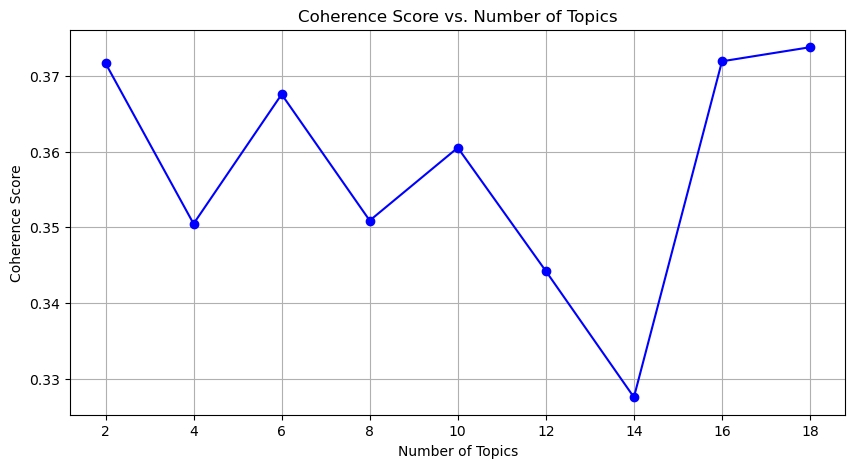

In [27]:
for i, doc in enumerate(doc_term_matrix):
    topic_distribution = ldamodel[doc]
    print(f"Document {i}: {topic_distribution}")

from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text_unicode_array, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_score}')

coherence_scores = []
topic_range = range(2, 20, 2)  # Test topics from 2 to 20

for num in topic_range:
    temp_model = Lda(doc_term_matrix, num_topics=num, id2word=dictionary, passes=20)
    coherence_model = CoherenceModel(model=temp_model, texts=processed_text_unicode_array, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid(True)
plt.show()


In [28]:
topics_words = {i: [word for word, _ in ldamodel.show_topic(i, topn=10)] for i in range(topic_num)}
pprint(topics_words)

{0: ['game',
     'nintendo',
     'switch',
     'china',
     'deriviere',
     'ai',
     'chip',
     'age',
     'rule',
     'u'],
 1: ['data',
     'security',
     'company',
     'percent',
     'also',
     'social',
     'chandrashekar',
     'organization',
     'threat',
     'fire'],
 2: ['data',
     'ai',
     'musk',
     'mukkala',
     'galaxy',
     'star',
     'new',
     'cancer',
     'agent',
     'operator'],
 3: ['ai',
     'data',
     'technology',
     'business',
     'system',
     'digital',
     'solution',
     'new',
     'industry',
     'company'],
 4: ['pi',
     'treatment',
     'periodontitis',
     'study',
     'could',
     'patient',
     'approach',
     'disease',
     'condition',
     'identified'],
 5: ['levven',
     'minute',
     'keirstead',
     'visit',
     'second',
     'average',
     'home',
     'switch',
     'tool',
     'industry'],
 6: ['ai',
     'technology',
     'digital',
     'business',
     'company',
     'syst

## Conclusion

Topic 0: **This topic is relevant to Apple in terms of AI, chips, and gaming (Switch, Nintendo)**. While Apple focuses on AI, chips, and gaming integration through platforms like Apple Arcade, it's more directly associated with gaming and technology.

Topic 1: **This topic is highly relevant due to Apple's focus on data security and privacy**, particularly in the context of their user data protection measures. Apple's reputation centers on its commitment to user security.

Topic 2: **Apple is less directly connected to topics like Musk, Galaxy, and cancer**, but the AI and data aspects have relevance, particularly in how AI is used in Apple's products (like Siri and machine learning models).

Topic 3: **This topic is highly relevant to Apple, as it focuses on AI, technology, digital systems, and business solutions**, all core aspects of Apple's operations in developing cutting-edge products and services.

Topic 4: **This topic seems less relevant to Apple, as it pertains more to medical studies, particularly periodontitis and treatment**, which doesn't directly tie into Apple's primary focus on consumer tech.

Topic 5: **This topic appears less relevant**, though the mention of switch could loosely connect to Apple’s hardware and industry focus, but the rest is less aligned with their focus.

Topic 6: **This topic is relevant, given the mention of AI, technology, business, and innovation.** Apple's commitment to innovation and the tech industry makes this highly aligned with their brand. 

Topic 7: **This topic is somewhat relevant due to the AI, China, and data aspects.** While Apple has significant operations in China, the topic also includes references to other entities like Meta and specific AI tools, which may not be as directly aligned.

Topic 8: **This topic is relevant due to the focus on AI, technology, security, and digital business, aligning with Apple's areas of focus**, especially with regard to AI and security features in their devices.

Topic 9: **This topic is not directly relevant to Apple**, as it focuses on health studies like vitamin, stroke, and typhoid, which don't align with Apple’s core business areas.